# Project: Geo-pulse - Clustering of area_codes

---

## 1. Importing Libraries

In [1]:
# General Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sci-kit learn Library
# Machine learning models
from sklearn.cluster import KMeans, DBSCAN
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.ensemble import RandomForestClassifier

# Pre-process
from sklearn.model_selection import train_test_split

# Metrics
from yellowbrick.classifier import ClassificationReport

# Setting palette
sns.set_palette('colorblind')
sns.set_style("whitegrid", {'axes.grid' : False})

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/geo_cleaned.csv', index_col=[0])

In [3]:
df.drop(columns=['area_code'],inplace=True)

In [4]:
df.head()

,hour,segment,density,pre_paid,post_paid,gender_male,gender_female,gender_unknown,age_1_19,age_20_29,...,pct_fastfood_app_user,pct_food_delivery_app_user,pct_grocery_delivery_app_user,pct_inte_coffee_lover,pct_inte_travel_and_information,pct_inte_investment,pct_inte_realestate,pct_inte_insurance,pct_inte_automobile,pct_inte_fitness_and_wellness
0,18,visitor,28,9,19,5,11,12,6,7,...,0.035714,0.392857,0.107143,0.357143,0.142857,0.107143,0.071429,0.000000,0.107143,0.107143
1,1,visitor,37,17,20,10,8,19,8,3,...,0.027027,0.189189,0.027027,0.162162,0.027027,0.054054,0.000000,0.000000,0.108108,0.081081
2,16,worker,43,21,22,11,9,23,5,7,...,0.000000,0.186047,0.186047,0.116279,0.069767,0.069767,0.093023,0.069767,0.116279,0.093023
3,12,visitor,21,12,9,8,6,7,3,7,...,0.000000,0.190476,0.190476,0.190476,0.000000,0.000000,0.000000,0.000000,0.047619,0.047619
4,11,work_at_home,31,11,20,6,7,18,3,2,...,0.000000,0.193548,0.096774,0.354839,0.032258,0.064516,0.064516,0.000000,0.129032,0.032258


---

## 2. Data Preparation

**Select only population density column**

In [5]:
# segment and density will be our features to cluster
df = df[['segment','density','time_of_day']]

---

## 3. KMeans by time of the day

We have separated our segments into 4 segments - `visitor`, `worker`, `resident`, and `work_at_home` - because every grid is unique, therefore comparing different segments at different locations will not be beneficial. Focusing on each segment, we will do unsupervised clustering based on `time_of_day` - `Morning`, `Work`, `Afterwork`, `Sleep`. This should be able to provide us with some clues on how the grids can be cluster and what sets each grids apart.

However, if each binning of segments and time_of_day has too little rows of data, then clustering will not work. We will select only groups of grids with > 40 rows to do clustering.

In [6]:
grouped = df.groupby(['segment'])['density'].count()\
.to_frame()
grouped['Usability'] = grouped['density'].map(
    lambda x : np.where(x < 40, 'too small', 'can use'))

In [7]:
grouped.style.background_gradient()

,density,Usability
segment,,
resident,182,can use
visitor,312,can use
work_at_home,370,can use
worker,128,can use


**Creating function to identify optimal k using both inertia elbow method and silhouette coefficients distribution**

In [8]:
def cluster(data,segment, max_cluster):
    
    X = data[data['segment'] == segment].drop(
        columns=['segment'])
    X = pd.get_dummies(X,columns=['time_of_day'],drop_first=True)
    
    # Inertia
    km = KMeans(random_state=42)
    visualizer = KElbowVisualizer(km,k=(2,max_cluster))
    visualizer.fit(X)
    visualizer.show()
    
    # Silhouette Score
    fig, ax = plt.subplots(max_cluster//2, 2, figsize=(10,max_cluster))
    
    for i in range(2,max_cluster+1):

        km = KMeans(n_clusters=i, init='k-means++', n_init=10,
                    max_iter=100, random_state=42)
        q, mod = divmod(i, 2)
        
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick',
                                          ax=ax[q-1][mod])
        visualizer.fit(X)
        
    plt.tight_layout()

### 3.1 Resident Segment

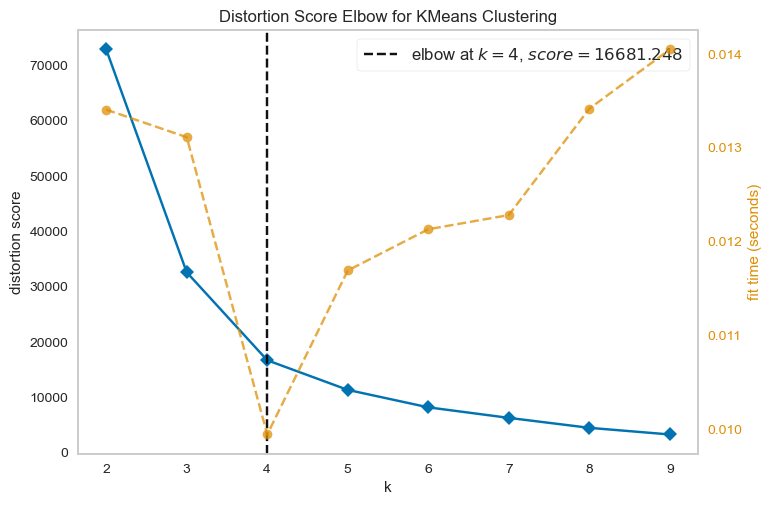

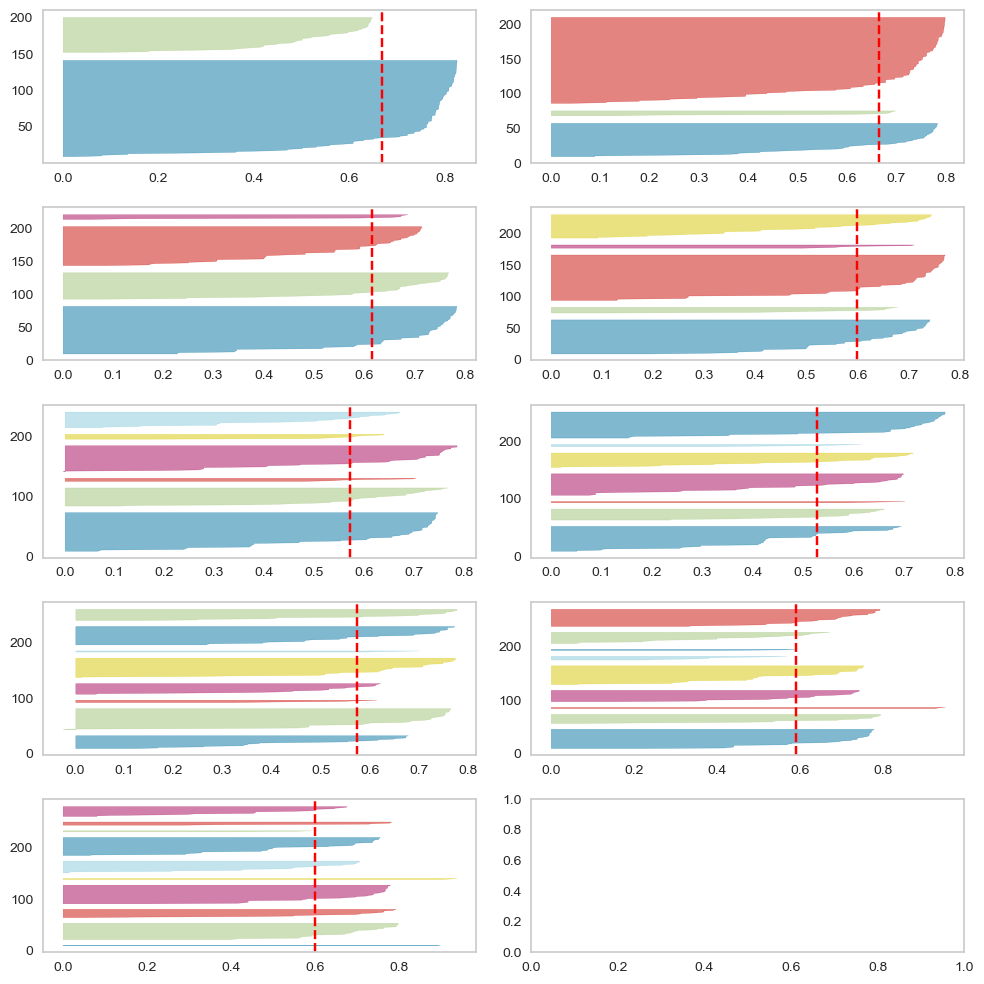

In [9]:
cluster(df,'resident',10)

### 3.2 Working

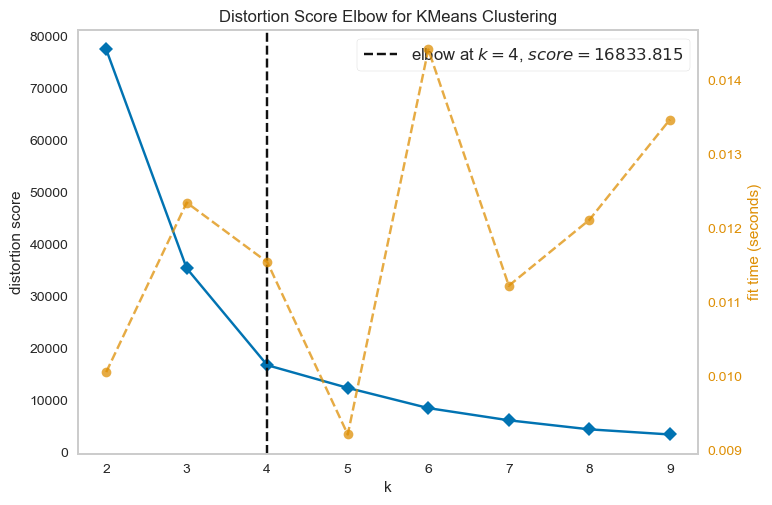

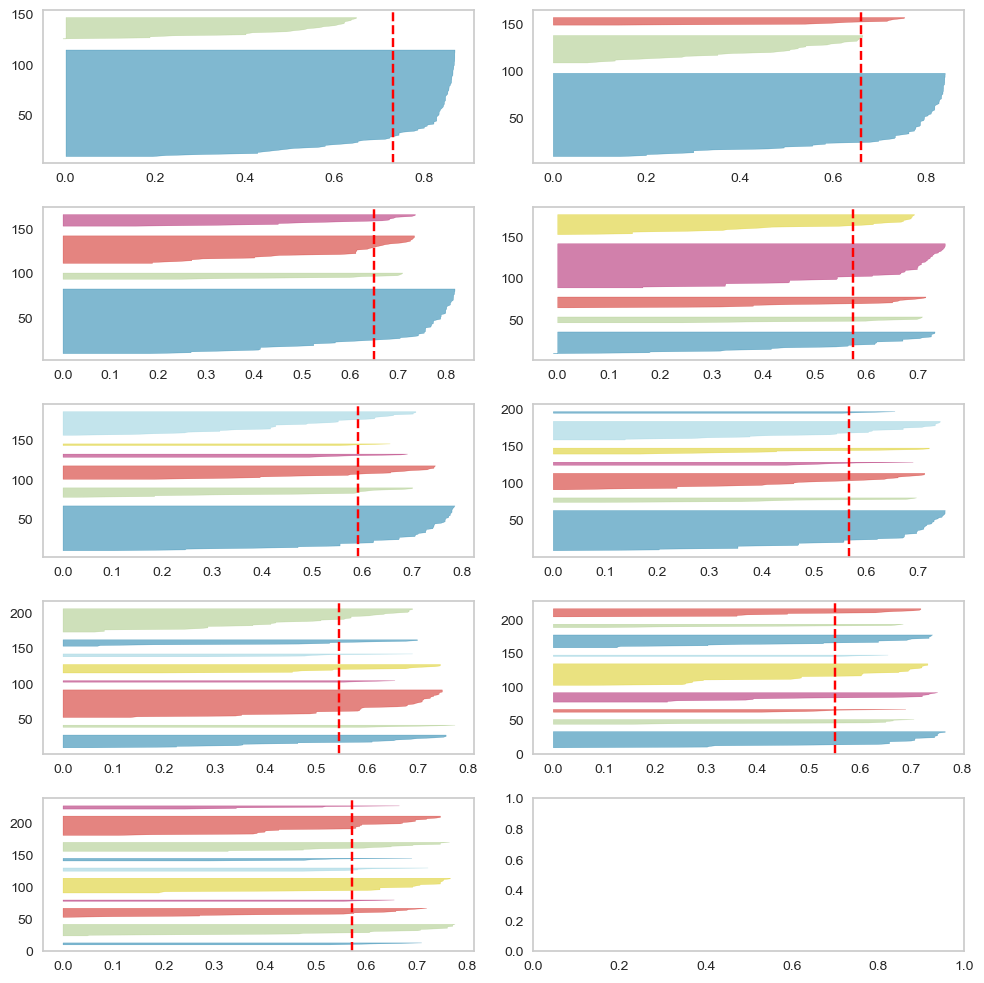

In [10]:
cluster(df,'worker',10)

**Interpretation:**
- Elbow method suggested the optimal k is 4
- Looking at the Silhouette coefficients distribution of each k and the evenness of clusters, k = 3-5 seems to create a sensible grouping
- We will try both 3-5 clusters, then assess the insights we get from them

### 3.3 Visitor

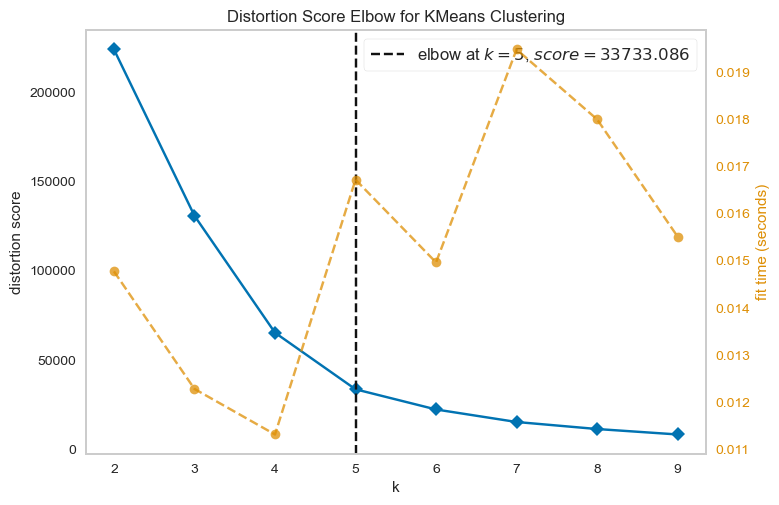

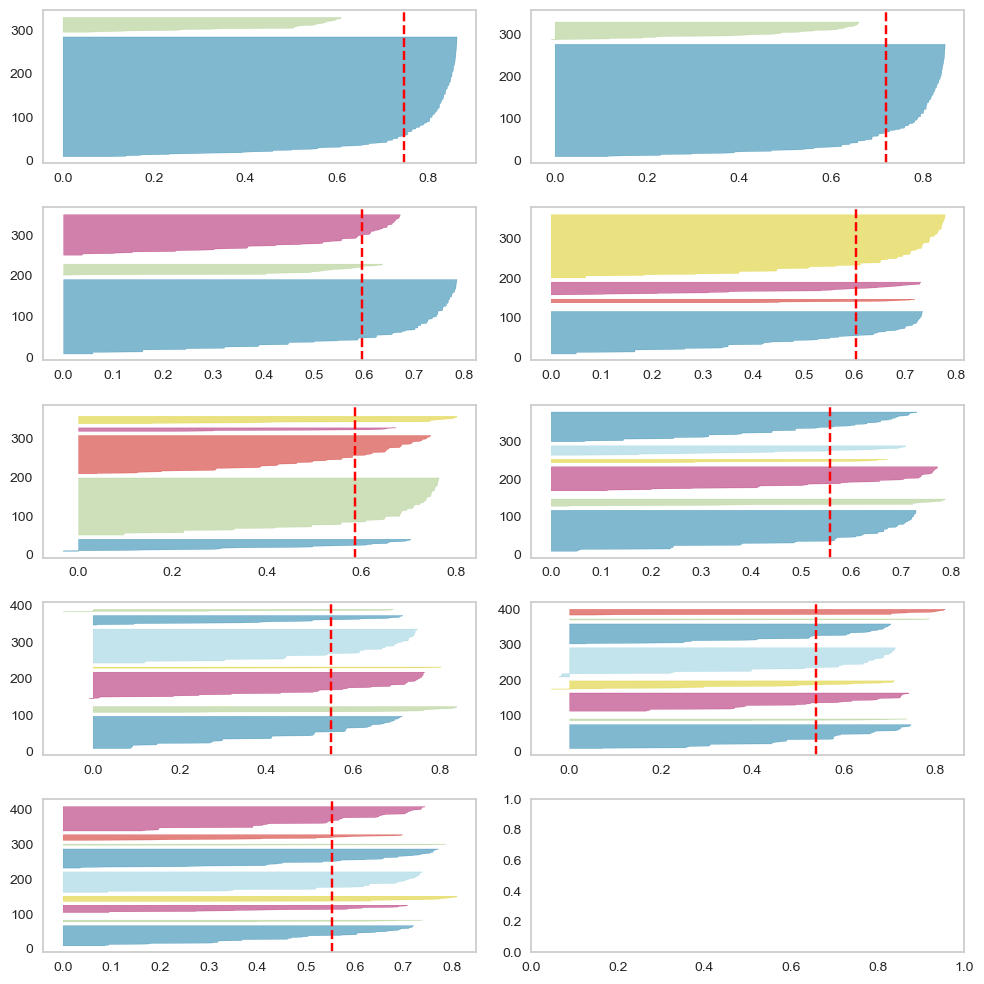

In [11]:
cluster(df,'visitor',10)

**Interpretation:**
- Elbow method suggested the optimal k is 4
- Looking at the Silhouette coefficients distribution of each k and the evenness of clusters, k = 4 should work best as an outlier group always exist
- We will try 4 clusters, then assess the insights we get from them

### 3.4 Work at home

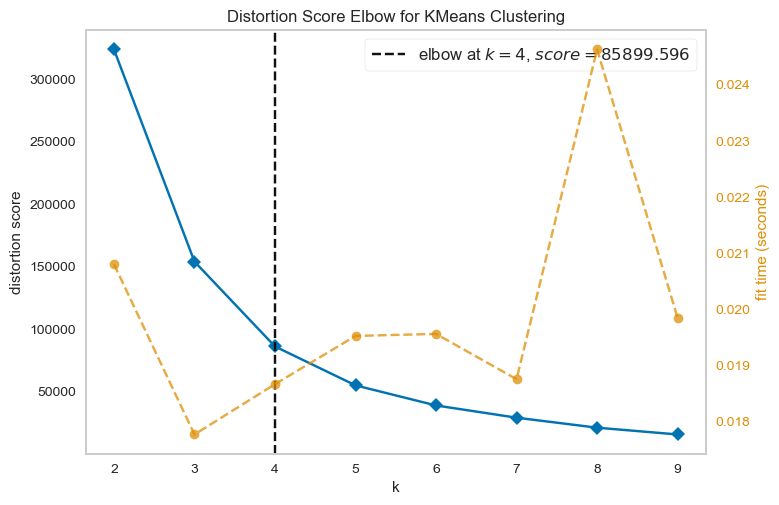

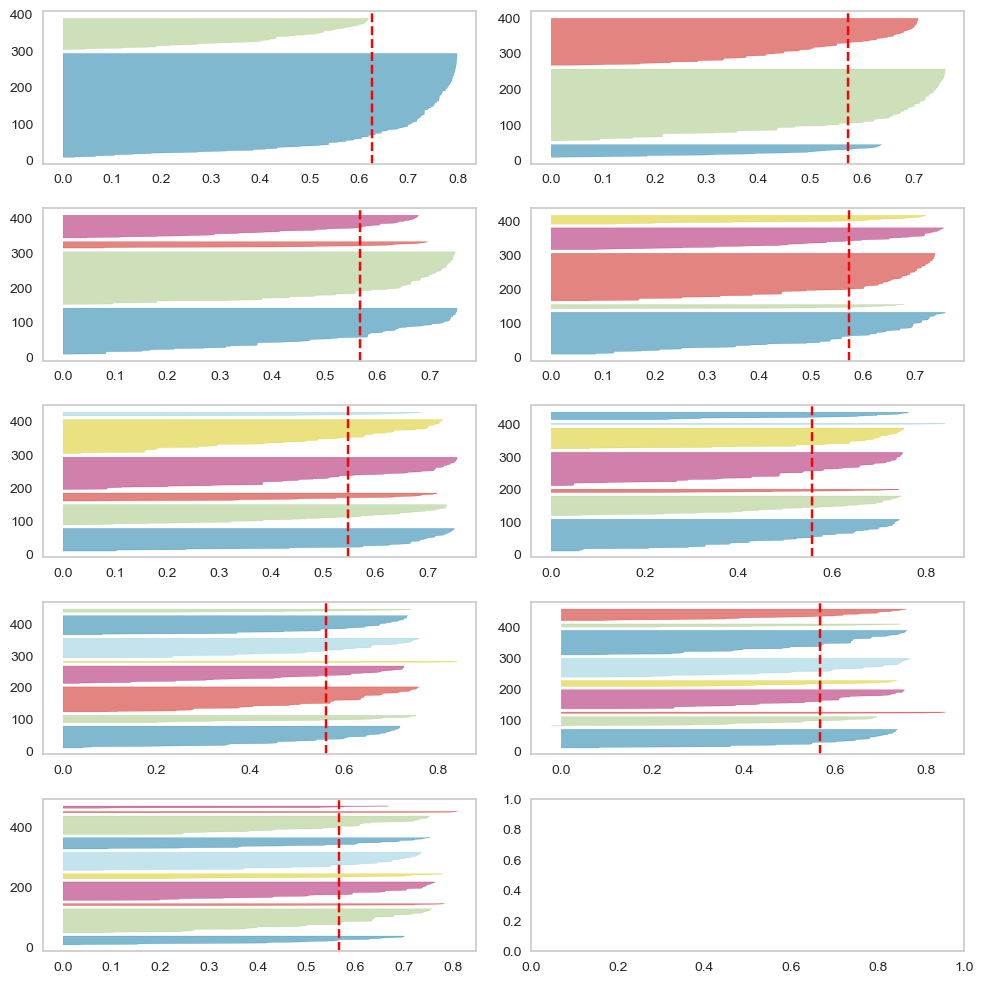

In [12]:
cluster(df,'work_at_home',10)

**Interpretation:**
- Elbow method suggested the optimal k is 4
- Looking at the Silhouette coefficients distribution of each k and the evenness of clusters, k = 4 is definitely the winner in this case
- We will try 4 clusters, then assess the insights we get from them

---

## 4. Unsupervised KMeans clustering feeding into Supervised classifier to identify feature importance and grouping based on real world scenarios

**Function to generate labels based on selected `n_clusters`, with the option of separating the dataset by `time_of_day`**

In [13]:
def km_label(data,segment,num_clusters):

    clf_df = data[data['segment']==segment]
    X = clf_df.copy().drop(columns=['segment'])
    X = pd.get_dummies(X, columns=['time_of_day'])
    
    km = KMeans(n_clusters=num_clusters, random_state=42)
    km.fit(X)

    clf_df['labels'] = km.labels_
    X['labels'] = km.labels_
    
    clf_gb = (X.groupby('labels').agg({'density': ['count', 'mean'],
                                      'time_of_day_Morning':['mean'],
                                      'time_of_day_Work':['mean'],
                                      'time_of_day_Afterwork':['mean'],
                                      'time_of_day_Sleep':['mean']}).round(2))
    clf_gb.round(2)

    return X, clf_df, clf_gb

**Function to create classification report**

In [14]:
def clf_reports(model,clf_df):
    
    clf = model
    
    X = clf_df.drop(columns=['labels'])
    y = clf_df['labels']
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)
    
    classes = y_train.unique()
    
    visualizer = ClassificationReport(clf, classes=classes, support=True)
    visualizer.fit(X_train,y_train)
    visualizer.score(X_test,y_test)
    visualizer.ax.tick_params(axis='x', labelrotation=90.)
    visualizer.show()
    
    result = pd.DataFrame({'feature':clf.feature_names_in_,
                                       'importance':clf.feature_importances_})
    result = result.sort_values(by='importance',ascending=False)
    
    return result

**Function to create kde plot of each clusters***

In [15]:
def plot_kde_by_labels(df,time):
    plt.figure(figsize=(4,4))
    plt.title(f"Scatter plot of population density distribution of {time} bin of data")
    sns.kdeplot(data=df,x='density',hue='labels')

**Criteria of labeling:** <br>

Density:
- Low <= 40
- 40 < Medium <= 80
- 80 < High

Cluster Type:
- Residential : Have residents all day except during working hours
- Community : Have residents all day including some residents during working hours (this grid has work available)
- Office : Worker mostly during work and afterwork
- Community_office : Worker approximately the same during morning and work time
- Public : Visitors during all hours (Note: at medium or high density)
- Misc : Visitors during all hours (but low density level)


**This interpretation will be applied to all bins**

### 4.1 Resident

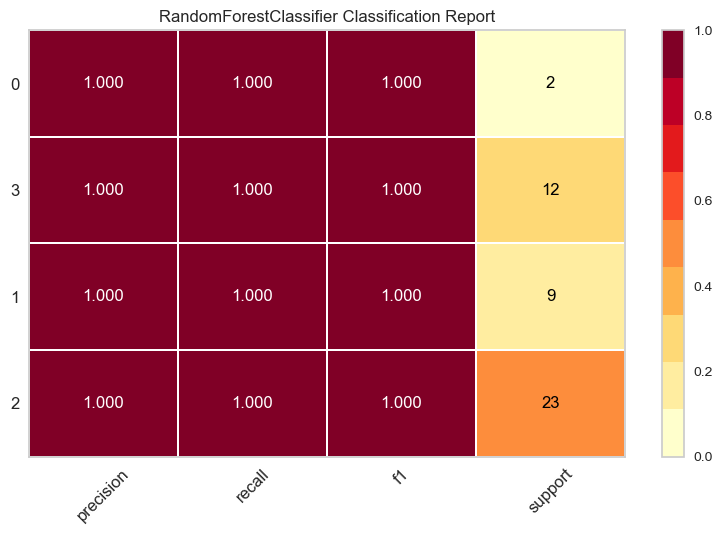

,feature,importance
0,density,0.900811
4,time_of_day_Work,0.050356
3,time_of_day_Sleep,0.030536
1,time_of_day_Afterwork,0.012705
2,time_of_day_Morning,0.005593


In [16]:
resident_X, resident_clf_df,resident_clf_gb = km_label(df,'resident',4)
important_features = clf_reports(RandomForestClassifier(random_state=42),resident_X)
important_features

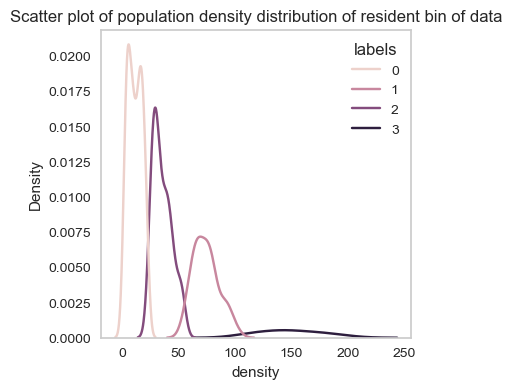

In [17]:
plot_kde_by_labels(resident_clf_df,'resident')

In [18]:
resident_clf_gb

density         time_of_day_Morning time_of_day_Work  \
         count    mean                mean             mean   
labels                                                        
0           73   11.64                0.14             0.36   
1           41   74.32                0.07             0.00   
2           60   35.70                0.17             0.00   
3            8  148.75                0.12             0.00   

       time_of_day_Afterwork time_of_day_Sleep  
                        mean              mean  
labels                                          
0                       0.33              0.18  
1                       0.24              0.68  
2                       0.40              0.43  
3                       0.25              0.62

In [19]:
# Mapping to morning_results dataframe
resident_results = resident_clf_df.copy()
resident_results['density_level'] = resident_results['labels'].map({0:'low',1:'low',2:'high',3:'medium'})
resident_results['location_type'] = resident_results['labels'].map({0:'residential',1:'community',\
    2:'residential',3:'residential'})

### 4.2 Worker

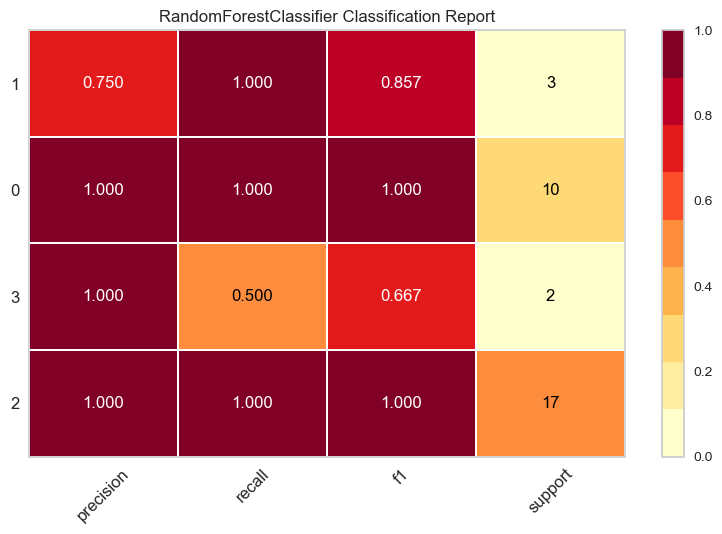

,feature,importance
0,density,0.886125
4,time_of_day_Work,0.050118
1,time_of_day_Afterwork,0.032804
2,time_of_day_Morning,0.026317
3,time_of_day_Sleep,0.004637


In [20]:
worker_x, worker_clf_df,worker_clf_gb = km_label(df,'worker',4)
important_features = clf_reports(RandomForestClassifier(random_state=42), worker_x)
important_features

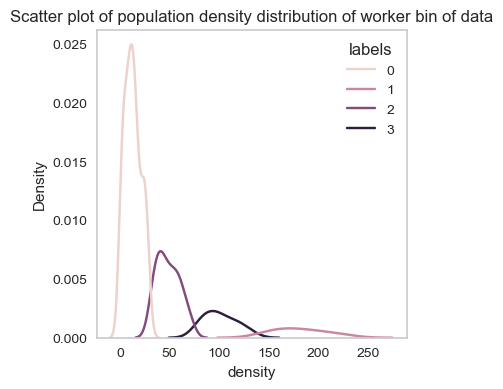

In [21]:
plot_kde_by_labels(worker_clf_df,'worker')

In [22]:
worker_clf_gb

density         time_of_day_Morning time_of_day_Work  \
         count    mean                mean             mean   
labels                                                        
0           74   13.07                0.15             0.50   
1            8  180.75                0.00             1.00   
2           32   48.72                0.06             0.94   
3           14  101.07                0.43             0.57   

       time_of_day_Afterwork time_of_day_Sleep  
                        mean              mean  
labels                                          
0                        0.3              0.05  
1                        0.0              0.00  
2                        0.0              0.00  
3                        0.0              0.00

In [23]:
# Mapping to working_results dataframe
worker_results = worker_clf_df.copy()
worker_results['density_level'] = worker_results['labels'].map({0:'low',1:'high',2:'medium',3:'high'})
worker_results['location_type'] = worker_results['labels'].map({0:'office',1:'office',
2:'office',3:'community_office'})

### 4.3 Work At Home

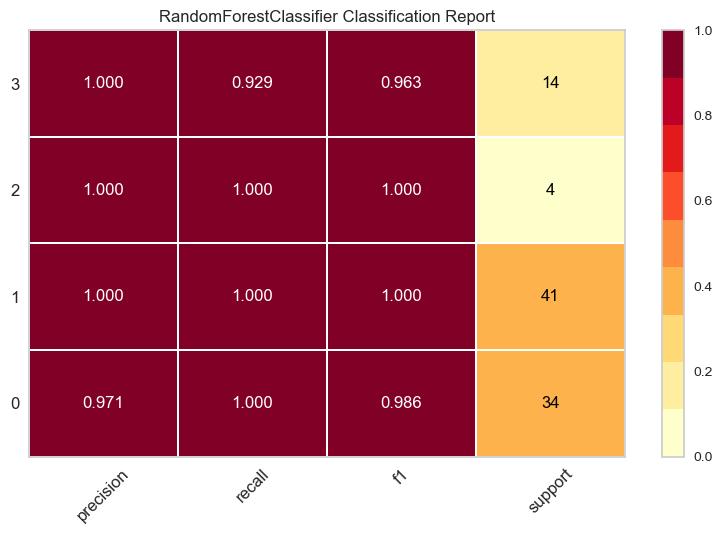

,feature,importance
0,density,0.981536
2,time_of_day_Morning,0.006403
4,time_of_day_Work,0.006062
3,time_of_day_Sleep,0.003049
1,time_of_day_Afterwork,0.002950


In [24]:
wfh_x, wfh_clf_df, wfh_clf_gb = km_label(df,'work_at_home',4)
important_features = clf_reports(RandomForestClassifier(random_state=42), wfh_x)
important_features.head(5)

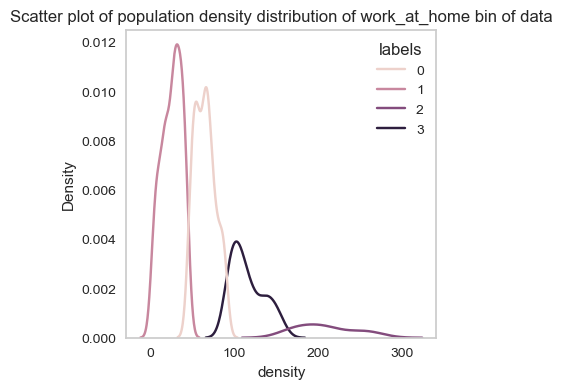

In [25]:
plot_kde_by_labels(wfh_clf_df,'work_at_home')

In [26]:
wfh_clf_gb

density         time_of_day_Morning time_of_day_Work  \
         count    mean                mean             mean   
labels                                                        
0          133   64.86                0.11             0.40   
1          152   25.28                0.17             0.33   
2           19  208.16                0.16             0.32   
3           66  115.53                0.17             0.29   

       time_of_day_Afterwork time_of_day_Sleep  
                        mean              mean  
labels                                          
0                       0.25              0.24  
1                       0.25              0.25  
2                       0.32              0.21  
3                       0.27              0.27

In [27]:
# Mapping to morning_results dataframe
wfh_results = wfh_clf_df.copy()
wfh_results['density_level'] = wfh_results['labels'].map({0:'low',1:'high',2:'high',3:'medium'})
wfh_results['location_type'] = wfh_results['labels'].map({0:'residential',1:'residential',
2:'residential',3:'residential'})

### 4.4 Visitor

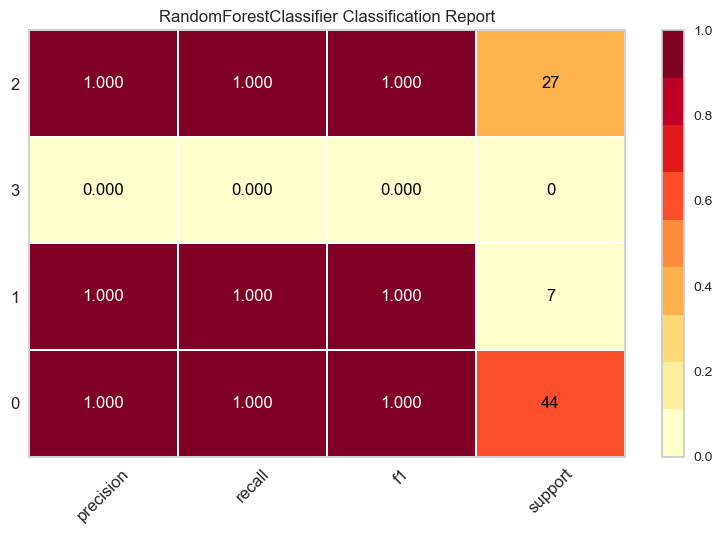

,feature,importance
0,density,0.981011
3,time_of_day_Sleep,0.007721
1,time_of_day_Afterwork,0.004672
4,time_of_day_Work,0.003564
2,time_of_day_Morning,0.003033


In [28]:
visitor_x, visitor_clf_df, visitor_clf_gb = km_label(df,'visitor',4)
important_features = clf_reports(RandomForestClassifier(random_state=42),visitor_x)
important_features

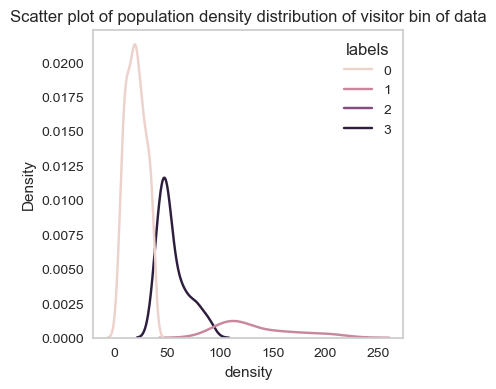

In [29]:
plot_kde_by_labels(visitor_clf_df,'visitor')

In [30]:
visitor_clf_gb

density         time_of_day_Morning time_of_day_Work  \
         count    mean                mean             mean   
labels                                                        
0          183   20.34                0.14             0.38   
1           28  133.79                0.14             0.43   
2            1  431.00                1.00             0.00   
3          100   54.80                0.19             0.40   

       time_of_day_Afterwork time_of_day_Sleep  
                        mean              mean  
labels                                          
0                       0.25              0.23  
1                       0.32              0.11  
2                       0.00              0.00  
3                       0.27              0.14

In [31]:
# Mapping to morning_results dataframe
visitor_results = visitor_clf_df.copy()
visitor_results['density_level'] = visitor_results['labels'].map({0:'low',1:'high',2:'high',3:'medium'})
visitor_results['location_type'] = visitor_results['labels'].map({0:'public',1:'misc',
2:'public',3:'public'})


---

**This method could potentially have many use cases in the future as it allows GeoPulse to leverage it's existing dataset to create grid labeling that benefits more other businesses. Allowing GeoPulse to expand it's partner without having to further invest in more data collection**

<br>

**This binning technique is easier to interpret than binning by time of day**